In [516]:
import torch.utils.data as data
import torch.optim as optim
from IPython.display import clear_output
import time
import glob
import torch.nn as nn
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import random, os
import matplotlib.pyplot as plt
import torchvision.models as models
from pytorch_model_summary import summary

In [517]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [518]:
# random.seed(42)

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, width=128, height=128, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.img_size = (width, height)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)

        original_width, original_height = self.img_size

        img = img.resize(self.img_size)
        img = np.array(img)

        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'dog':
            label = torch.tensor([1, 0], dtype=torch.float32)
        elif label == 'cat':
            label = torch.tensor([0, 1], dtype=torch.float32)
        return to_tensor(img), label

In [519]:
samples = glob.glob(os.path.join('./dog-vs-cats/train', '*.jpg'))

nr_samples = len(samples)
samples = random.sample(samples, nr_samples)

total_samples = len(samples)
train_split = int(0.85 * total_samples)

# Split the data into train, test, and validation sets
train_samples = samples[:train_split]
test_samples = samples[train_split:]

print(len(train_samples))
print(len(test_samples))

cats_dogs_train = CatsDogsDataset(train_samples, width=224, height=224)
cats_dogs_test = CatsDogsDataset(test_samples, width=224, height=224)

train_loader_resnet18 = DataLoader(cats_dogs_train, batch_size=16, shuffle=True)
test_loader_resnet18 = DataLoader(cats_dogs_test, batch_size=16, shuffle=False)

# images, labels = next(iter(train_loader_resnet18))
# print(images.shape)
# print(labels)

21250
3750


In [520]:
# for (imgs, label) in zip(images, labels):
#     clear_output(wait=True)
#     image = imgs.numpy().transpose(1, 2, 0)
#     plt.imshow(image)
#     # plt.text(5, 15, "DOG" if label else "CAT", fontsize='xx-large', color='red', fontweight='bold')
#     plt.show()
# 
#     # if i >= see_examples - 1:
#     #     break
#     time.sleep(1)

In [521]:
resnet18 = models.resnet18(pretrained=True)
num_classes = 2
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, num_classes),
    nn.Softmax(dim=1)
)
# resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.to(device)

In [522]:
# freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# unfreeze last 2 layers
# for param in resnet18.layer2.parameters():
#     param.requires_grad=True
for param in resnet18.layer3.parameters():
    param.requires_grad = True
for param in resnet18.layer4.parameters():
    param.requires_grad = True
for param in resnet18.avgpool.parameters():
    param.requires_grad = True
for param in resnet18.fc.parameters():
    param.requires_grad = True


In [523]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [524]:
print(summary(resnet18, torch.rand(size=(16, 3, 224, 224)).to(device), show_input=True))

-------------------------------------------------------------------------------
           Layer (type)            Input Shape         Param #     Tr. Param #
               Conv2d-1      [16, 3, 224, 224]           9,408               0
          BatchNorm2d-2     [16, 64, 112, 112]             128               0
                 ReLU-3     [16, 64, 112, 112]               0               0
            MaxPool2d-4     [16, 64, 112, 112]               0               0
           BasicBlock-5       [16, 64, 56, 56]          73,984               0
           BasicBlock-6       [16, 64, 56, 56]          73,984               0
           BasicBlock-7       [16, 64, 56, 56]         230,144               0
           BasicBlock-8      [16, 128, 28, 28]         295,424               0
           BasicBlock-9      [16, 128, 28, 28]         919,040         919,040
          BasicBlock-10      [16, 256, 14, 14]       1,180,672       1,180,672
          BasicBlock-11      [16, 256, 14, 14]     

In [525]:
dummy = torch.rand(size=(16, 3, 224, 224), dtype=torch.float32).to(device)
train_accuracy = torch.tensor(0., device=device)
out = resnet18(dummy)
preds = [[0 ,1]]
correct = (torch.argmax(out, dim=1) == 1).sum()
# correct = torch.sum(correct).item()
print(train_accuracy)
train_accuracy += correct
print(train_accuracy)

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


In [526]:

def train_fn(epochs: int, train_loader: data.DataLoader, test_loader: data.DataLoader,
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer):
    train_accuracy_list = []
    train_loss_list = []
    valid_accuracy_list = []
    valid_loss_list = []
    
    # Iteram prin numarul de epoci
    for e in range(epochs):
        print(f"Epoch {e + 1}/{epochs}")
        net.train()
        train_loss = torch.tensor(0., device=device)
        train_accuracy = torch.tensor(0., device=device)

        # Iteram prin fiecare exemplu din dataset
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # Aplicam reteaua neurala pe imaginile de intrare
            out = net(images)
            # Aplicam functia cost pe iesirea retelei neurale si pe adnotarile imaginilor 
            loss = loss_fn(out, labels)
            # Aplicam algoritmul de back-propagation
            loss.backward()
            # Facem pasul de optimizare, pentru a aplica gradientii pe parametrii retelei
            optimizer.step()
            # Apelam functia zero_grad() pentru a uita gradientii de la iteratie curenta
            optimizer.zero_grad()
            # Update la train loss si accuratete
            with torch.no_grad():
                train_loss += loss * len(labels)
                train_accuracy += (torch.argmax(out, dim=1) == torch.argmax(labels, dim=1)).sum()
        
        train_loss = train_loss / len(train_samples)
        train_accuracy = 100 * train_accuracy / len(train_samples)
        
        print(f'Training loss: {train_loss:.2f}'.rjust(24))
        print(f'Training accuracy: {train_accuracy:.2f}'.rjust(23))
        
        train_loss_list.append(train_loss.cpu())
        train_accuracy_list.append(train_accuracy.cpu())

        if test_loader is not None:
            net.eval()

            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)

            with torch.no_grad():
                for test_images, test_labels in test_loader:
                    test_images, test_labels = test_images.to(device), test_labels.to(device)

                    predicted_labels = net(test_images)
                    loss = loss_fn(predicted_labels, test_labels)
                    
                    valid_loss += loss * len(test_labels)
                    valid_accuracy += (torch.argmax(predicted_labels, dim=1) == torch.argmax(test_labels, dim=1)).sum()
            
            valid_loss = valid_loss / len(test_samples) 
            valid_accuracy = 100 * valid_accuracy / len(test_samples)
            
            print(f'Valid loss: {valid_loss:.2f}'.rjust(24))
            print(f'Valid accuracy: {valid_accuracy:.2f}\n'.rjust(25))
            
            valid_loss_list.append(valid_loss.cpu())
            valid_accuracy_list.append(valid_accuracy.cpu())
        
    
    
    epochs = [x for x in range(epochs)]
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(epochs, train_accuracy_list, label='Training Accuracy', linestyle='-', color='b')
    ax1.plot(epochs, valid_accuracy_list, label='Validation Accuracy', linestyle='-', color='r')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(epochs, train_loss_list, label='Training Loss', linestyle='-', color='b')
    ax2.plot(epochs, valid_loss_list, label='Validation Loss', linestyle='-', color='r')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [527]:
# Definiti numarul de epoci
epochs = 10

# Definiti reteaua
# network = resnet18.to(device)

# Definiti optimizatorul
optimizer = optim.SGD(resnet18.parameters(), lr=0.0001)
"""
Dupa definirea optimizatorului si dupa fiecare iteratie de antrenare, trebui`e 
apelata functia zero_grad() pentru a seta valoare tuturor gradientilor la zero.
"""
# Completati aici codul pentru seta valoare tuturor gradientilor la zero
optimizer.zero_grad()

# Definiti functia cost pentru clasificare Cross-Entropy
# https://neptune.ai/blog/pytorch-loss-functions
loss_fn = nn.BCEWithLogitsLoss()

Epoch 1/10
     Training loss: 0.70
Training accuracy: 62.30
        Valid loss: 0.65
   Valid accuracy: 83.73

Epoch 2/10
     Training loss: 0.63
Training accuracy: 87.37
        Valid loss: 0.60
   Valid accuracy: 92.19

Epoch 3/10
     Training loss: 0.60
Training accuracy: 91.45
        Valid loss: 0.58
   Valid accuracy: 94.69

Epoch 4/10
     Training loss: 0.58
Training accuracy: 93.04
        Valid loss: 0.57
   Valid accuracy: 95.25

Epoch 5/10
     Training loss: 0.57
Training accuracy: 93.80
        Valid loss: 0.56
   Valid accuracy: 96.24

Epoch 6/10
     Training loss: 0.56
Training accuracy: 94.17
        Valid loss: 0.55
   Valid accuracy: 96.08

Epoch 7/10
     Training loss: 0.56
Training accuracy: 94.56
        Valid loss: 0.55
   Valid accuracy: 96.69

Epoch 8/10
     Training loss: 0.55
Training accuracy: 94.66
        Valid loss: 0.55
   Valid accuracy: 96.08

Epoch 9/10
     Training loss: 0.55
Training accuracy: 94.94
        Valid loss: 0.54
   Valid accuracy:

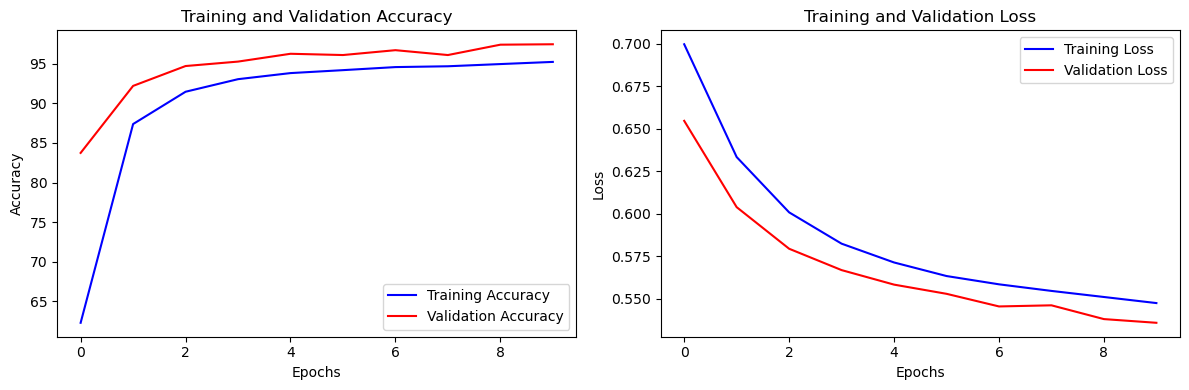

In [528]:
train_fn(epochs, train_loader_resnet18, test_loader_resnet18, resnet18, loss_fn, optimizer)